In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('/Users/jmunizbecerra/Desktop/pdb_data_seq.csv')
df_char = pd.read_csv('/Users/jmunizbecerra/Desktop/pdb_data_no_dups.csv')

In [2]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
# Checking classification
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [4]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [6]:
# Checking for any NA values
model_f.isnull().sum()

classification    1
sequence          3
dtype: int64

In [7]:
# Dropping missing values
model_f = model_f.dropna()

In [10]:
# Finding number of each class of protein
counts = model_f.classification.value_counts()
counts

HYDROLASE                            46336
TRANSFERASE                          36424
OXIDOREDUCTASE                       34321
IMMUNE SYSTEM                        15615
LYASE                                11682
                                     ...  
STRUCTURAL PROTEIN, CELL CYCLE           1
KINASE (GLYCOGEN METABOLISM)             1
SURFACE GLYCOPROTEIN                     1
IMMUNE SYSTEM,HYDROLASE INHIBITOR        1
antimicrobial                            1
Name: classification, Length: 4468, dtype: int64

In [13]:
# Identifying classes with over 1000 for machine learning model

# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

print(types)

['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM' 'LYASE'
 'HYDROLASE/HYDROLASE INHIBITOR' 'TRANSCRIPTION' 'VIRAL PROTEIN'
 'TRANSPORT PROTEIN' 'VIRUS' 'SIGNALING PROTEIN' 'ISOMERASE' 'LIGASE'
 'MEMBRANE PROTEIN' 'PROTEIN BINDING' 'STRUCTURAL PROTEIN' 'CHAPERONE'
 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION' 'SUGAR BINDING PROTEIN'
 'DNA BINDING PROTEIN' 'PHOTOSYNTHESIS' 'ELECTRON TRANSPORT'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'METAL BINDING PROTEIN'
 'CELL ADHESION' 'UNKNOWN FUNCTION' 'PROTEIN TRANSPORT' 'TOXIN'
 'CELL CYCLE' 'RNA BINDING PROTEIN' 'DE NOVO PROTEIN' 'HORMONE'
 'GENE REGULATION' 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'APOPTOSIS'
 'MOTOR PROTEIN' 'PROTEIN FIBRIL' 'METAL TRANSPORT'
 'VIRAL PROTEIN/IMMUNE SYSTEM' 'CONTRACTILE PROTEIN' 'FLUORESCENT PROTEIN'
 'TRANSLATION' 'BIOSYNTHETIC PROTEIN']


In [14]:
# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

In [16]:
# Naive Bayes Model

prediction = dict()

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.7638505396779861


<AxesSubplot:>

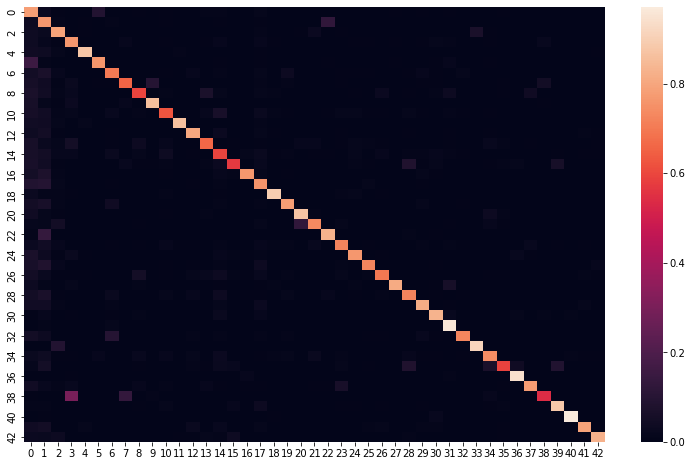

In [18]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, NB_pred, labels = types)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

In [19]:
#Print F1 score metrics
print(classification_report(y_test, NB_pred, target_names = types))

                                         precision    recall  f1-score   support

                              HYDROLASE       0.47      0.74      0.57       250
                            TRANSFERASE       0.60      0.82      0.70       211
                         OXIDOREDUCTASE       0.75      0.77      0.76       589
                          IMMUNE SYSTEM       0.66      0.72      0.69       509
                                  LYASE       0.91      0.76      0.83       859
          HYDROLASE/HYDROLASE INHIBITOR       0.66      0.88      0.76       224
                          TRANSCRIPTION       0.58      0.83      0.68       326
                          VIRAL PROTEIN       0.71      0.78      0.75       622
                      TRANSPORT PROTEIN       0.60      0.74      0.66       601
                                  VIRUS       0.91      0.97      0.94       209
                      SIGNALING PROTEIN       0.71      0.73      0.72       309
                           